# Train Logical Networks with PyTorch

This shows hacking the gradient descent method, defining the backpropagation of logical operations, and directly learning binary weights.

It allows direct learning of logic circuits, so I called it "Logical Network(LN)". (Some would call it Binary Neural Network (BNN).)

Codes : https://github.com/lilacs2039/FlipBackprop-pytorch

# Run anyway

We learn using the fastai style.

LN processing is described in ln.py.

## Setup

install requirements

In [ ]:
!wget https://raw.githubusercontent.com/lilacs2039/FlipBackprop-pytorch/main/v3/requirements.txt

In [ ]:
!pip install -r requirements.txt

Download codes

In [ ]:
!wget https://raw.githubusercontent.com/lilacs2039/FlipBackprop-pytorch/main/v3/ln.py

In [ ]:
import ln as ln

In [ ]:
from fastai.tabular.all import *
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import seaborn as sns
import yaml

In [ ]:
# ln.enable_log = False  # False if you want speed

In [ ]:
%reload_ext autoreload
%autoreload 2

## DataLoader

In [ ]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
cat_names = []
cont_names = iris.feature_names
dep_var = 'target'
def build_dls(bs=32):
    return TabularDataLoaders.from_df(df, 
                                     procs = [Categorify, FillMissing, Normalize],
                                     cat_names=cat_names,
                                     cont_names=cont_names, 
                                     y_names=dep_var, 
                                     y_block=CategoryBlock, 
                                     shuffle=True,
                                     bs=bs,
                                    )
dls = build_dls(bs=32)

In [ ]:
f'num train_ds(dataset) : {len(dls.train_ds)}'

'num train_ds(dataset) : 120'

In [ ]:
# batch shape
bx_cat, bx, by = dls.one_batch()
bx.shape, by.shape

(torch.Size([32, 4]), torch.Size([32, 1]))

In [ ]:
# batch example
bx_cat.flatten()[:2], bx.flatten()[:2], by.flatten()[:2]

(tensor([], dtype=torch.int64),
 tensor([-1.1406, -0.0660]),
 tensor([0, 0], dtype=torch.int8))

In [ ]:
# bx is normalized to mean:0, std:1
bx.mean(), bx.std()

(tensor(-0.0518), tensor(1.1052))

## Model

In [ ]:
class Model01(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, th_binarize, th_hidden):
        super().__init__()
        self.norm = torch.nn.BatchNorm1d(input_dim)
        self.binary_net = ln.Sequential([
            ln.Binarize(depth_ths=th_binarize),
            ln.BMAB(input_dim, hidden_dim, depth_in_features=len(th_binarize), depth_out_ths=th_hidden),
            ln.BMA(hidden_dim, output_dim, depth_in_features=len(th_hidden)),
        ])

    def forward(self, x_cat, x_cont):
        x = self.norm(x_cont)
        x = self.binary_net(x)
        return x

input_dim = len(cont_names)
hidden_dim = 64
output_dim = len(dls.vocab)  # or len(iris.target_names)
th_binarize = ln.TH_DEPTH3
th_hidden = ln.TH_DEPTH1
model = Model01(input_dim, hidden_dim, output_dim, th_binarize, th_hidden)

In [ ]:
model

Model01(
  (norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (binary_net): Sequential(
    (layers): ModuleList(
      (0): Binarize(
        depth_ths='tensor([[[-0.6700],
                 [ 0.0000],
                 [ 0.6700]]])'
      )
      (1): BMAB(
        depth_out_ths='tensor([[[0.]]])', in_features='4', out_features='64', depth_in_features='3'
        (layers): ModuleList(
          (0): XnorWeight(
            merge_operation=xnor
            (layers): ModuleList(
              (0): Identity()
              (1): BinaryTensor(weights=(3, 64, 1), dtype=uint8)
            )
          )
          (1): PcntNormBin(depth_ths='tensor([[[0.]]])', pcnt_reduce_pattern='b d ... o i -> b ... o', out_features='None')
        )
      )
      (2): BMA(
        in_features='64', out_features='3', depth_in_features='1'
        (layers): ModuleList(
          (0): XnorWeight(
            merge_operation=xnor
            (layers): ModuleList(
           

## Learn

In [ ]:
# ln.suppressor_rate = .5
ur=0.1
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,)
ln.setup_cbs(learn, ur_range=(ur, ur/10))

`find_ur`function finds the optimal update_rate(ur), like `learn.lr_find()` in fastai.

`update_rate` means percentage to flipping binary weights. It determines the learning speed, like `learning rate`.  
Typical value is around 0.05.

epoch,train_loss,valid_loss,accuracy,time
0,0.889858,0.669854,0.700000,00:03
1,0.922787,1.195344,0.600000,00:01


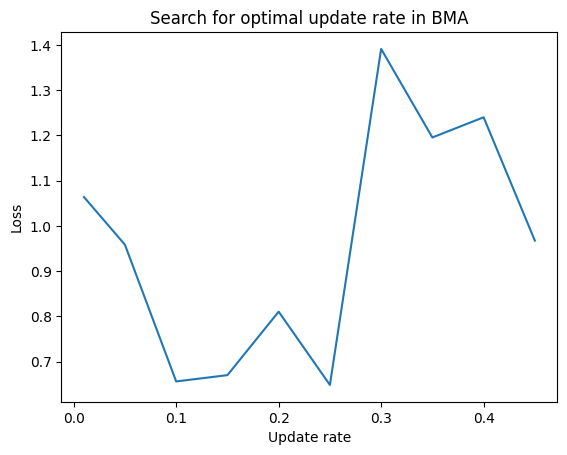

In [ ]:
# learn.lr_find()
ln.find_ur(learn)

epoch,train_loss,valid_loss,accuracy,time
0,1.099510,1.169478,0.333333,00:01
1,1.047170,0.909422,0.700000,00:01
2,1.059318,1.307766,0.533333,00:02
3,1.099017,0.594636,0.800000,00:02
4,1.003550,0.383917,0.833333,00:01
5,0.923753,0.463166,0.766667,00:02
6,0.872261,0.459882,0.833333,00:01
7,0.803005,0.459070,0.766667,00:01
8,0.766187,0.353707,0.833333,00:01
9,0.719611,0.351123,0.800000,00:02


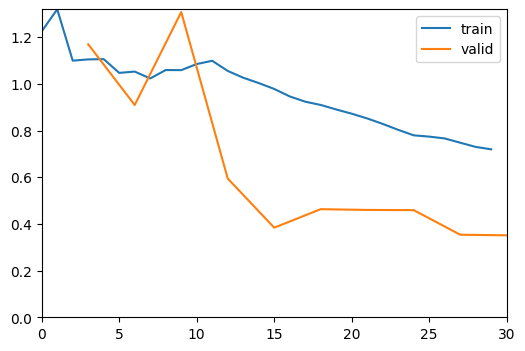

In [ ]:
learn.fit(10, cbs=[ShowGraphCallback(),])

## Results

In [ ]:
learn.show_results()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_pred
0,-1.497665,1.291360,-1.614490,-1.365992,0.0,0.0
1,1.477828,-0.065983,1.197477,1.193139,2.0,2.0
2,0.049592,-0.065983,0.738381,0.789066,2.0,2.0
3,1.239789,0.386465,1.082703,1.462521,2.0,2.0
4,1.001749,0.160241,1.025316,1.597213,2.0,2.0
5,-0.426487,1.065137,-1.442328,-1.365992,0.0,0.0
6,-0.069428,2.196256,-1.499715,-1.365992,0.0,0.0
7,0.049592,0.386465,0.566219,0.789066,1.0,2.0
8,0.049592,-0.065983,0.221897,0.384992,1.0,1.0


## Finished learning

Low accuracy? Please consider it's under development.

# What's happening?

Hack gradient descent to define back propagation of logic operations, and learn binary weights directly.

## Issue : Gradient descent not work

LN (or BNN) has binary weights and propagation tensor.  
Binary values are not continuous and cannot be learned by gradients.

## As is : Learn continuous & binarize

In the previous methods, the weights were binaryized after the weights of continuous values were learned by gradient. (i.e., indirect learning)

## To be : Learn binary by flip

In this Notebook, we use a method called "flip backprop" for learning.
This converts gradients to flip, and learn binary weights directly.

# Flip backprop

## Learning steps

1. Convert gradient to flip. (grad2flip)
2. back propagation (including logic operations)
3. Aggregate the flips and decide whether to update (flip) the binary weights

## Step1 : grad2flip

Flip is calculated from the grad sign, since it means the direction of value update.

An example is given below.

For the gradient descent method, if grad>0, the target value can be approached by decreasing.

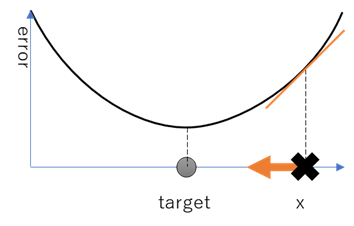

The same goes for the binary value. And if the value is 1, it can be flipped. That is, flip=1.

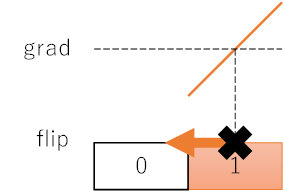

## Step2 : Backprop (XNOR, etc…)

The main component of LN is the BMA (Binary Multiply Accumulate).  
This corresponds to a linear layer.  
The XNOR operation weights the input variables and the Popcount operation sums them.

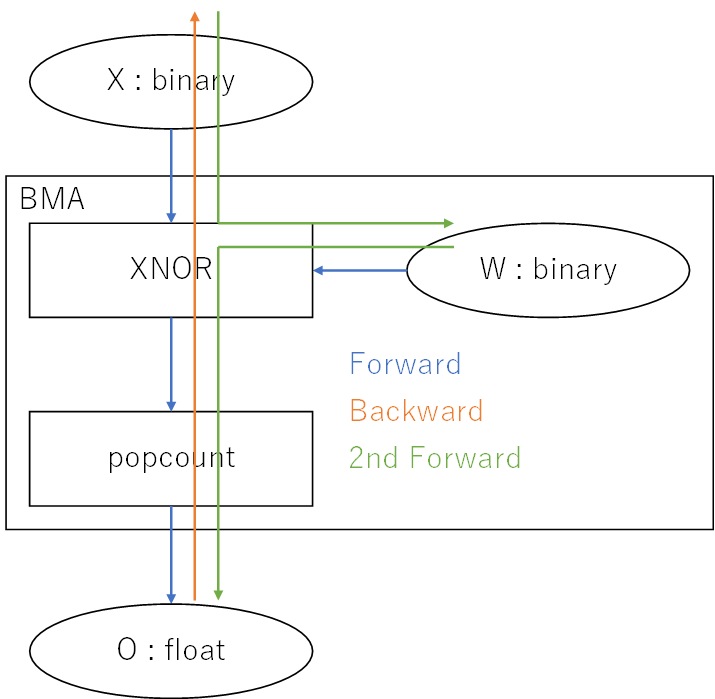

The definition of XNOR backpropagation is summarized in a truth table. From this, we understand "flip_A = flip_O".

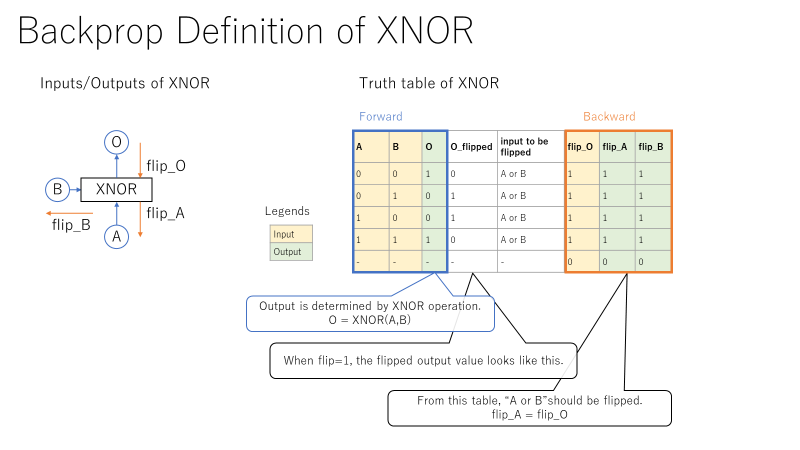


## Step3 : Update weight

Once the flip is back propagated to the binary weights, decide whether to aggregate and flip the binary weights.

Weights with larger sums are updated in priority.

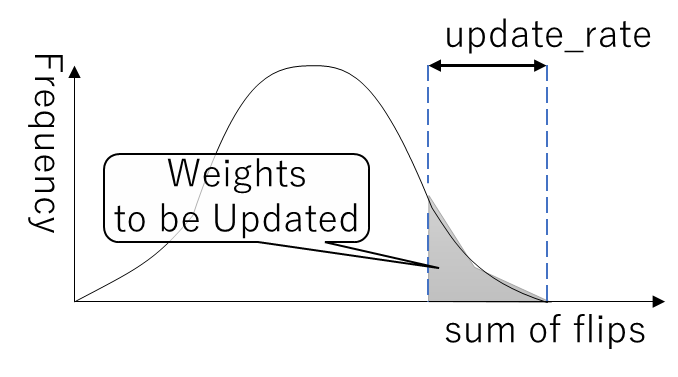

# Conclusion

We computed the flip from the sign of the gradient, defined the back propagation for the logical operations, and directly learned the binary weights.  
This is the foundation of the Logical network.

Want to know more? Visit the repository.

https://github.com/lilacs2039/FlipBackprop-pytorch

# ~ Appendix ~

# Backprop definition of logical operations

## AND

The definition of AND backpropagation is summarized in a truth table.   
From this, we understand "flip_A = AND(flip_O, XOR(A, O_flipped)".

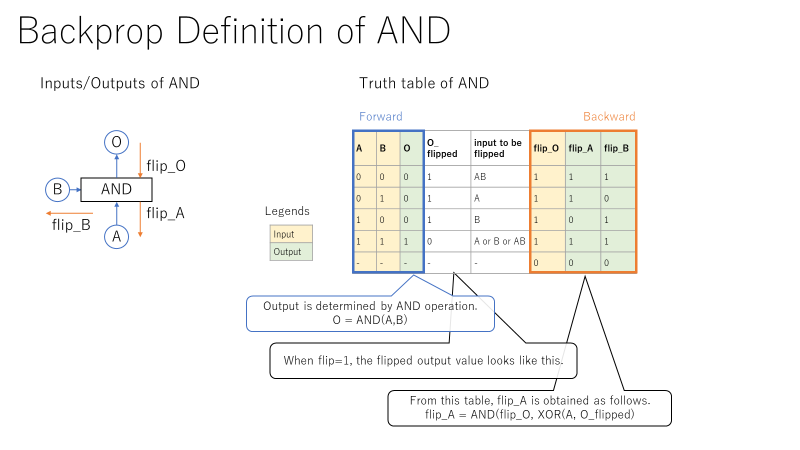

## OR

Do the same, we understand "flip_A = AND(flip_O, XOR(A, O_flipped)".
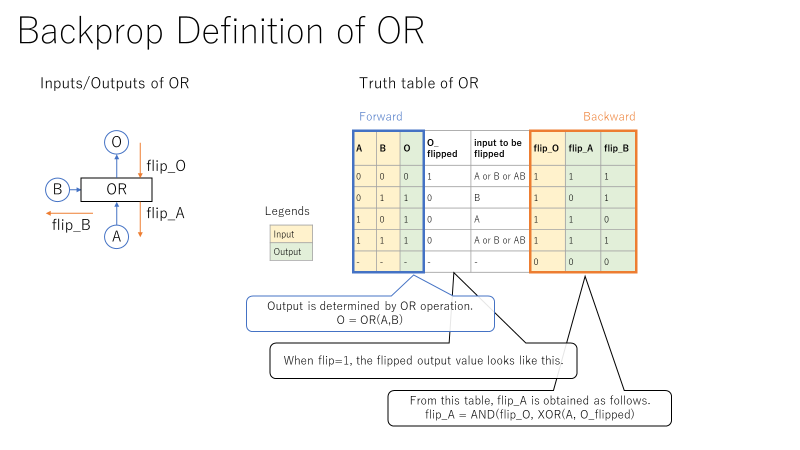

## Why XNOR?


XNOR is used because it can do both inc/dec.

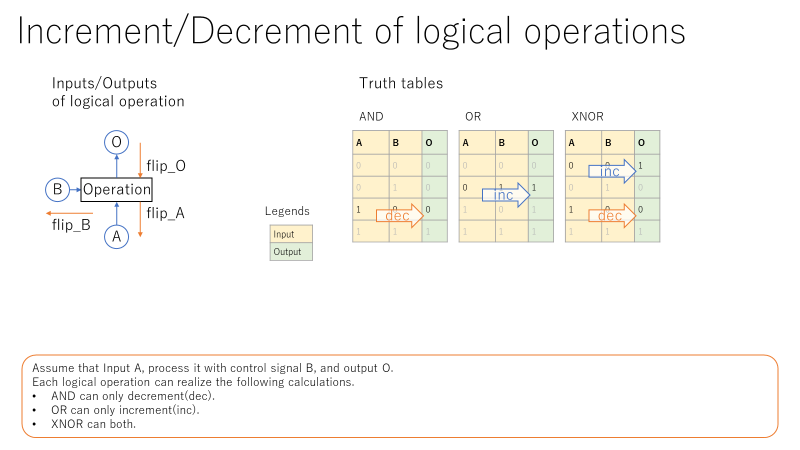

# Implementations

## Model Graph

PyTorch can't backward binary tensor, so all binary computations are done in `SequentialFunctionBackward` node (as shown the graph below).

It means, the node inputs a float tensor, internally computes a binary tensor, outputs a float tensor.

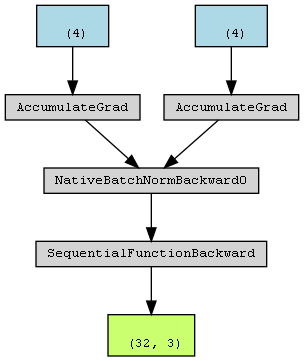

In [ ]:
ln.is_update=False
import torchvision.models as models
from torchviz import make_dot

dot = make_dot(model(bx_cat, bx.cuda()))
dot.format = 'png'
dot_path = 'outputs/graph_image'
dot.render(dot_path)

from IPython.display import Image
display(Image(filename=dot_path+'.png'))

## Model Parameters

Binary values are bitpacked and held in uint8 tensor.  
So that able to hold 1,736 parameters in just 248 bytes!

(Note that I didn't use PyTorch `BoolTensor`, since it holds only 1 bit per byte.)

In [ ]:
ln.create_parameters_info(model)

,dtype,param_shape,1ratio,num_params,size[Byte]
name,,,,,
norm.weight,torch.float32,[4],nan,4,16
norm.bias,torch.float32,[4],nan,4,16
Seq.1-BMAB.0-XnorWeight.1-BinaryTensor.weights,torch.uint8,"[3, 64, 1]",0.512,"1,536",192
Seq.2-BMA.0-XnorWeight.1-BinaryTensor.weights,torch.uint8,"[1, 3, 8]",0.568,192,24
Total,NaN,NaN,nan,"1,736",248


# Sweep with wandb

Before this, setup Weights & Bias.
https://www.wandb.ai/

Weights & Biases is a support tool for tracking experimental results, etc.

In [ ]:
%stop  # Stop when 'Run all'

UsageError: Line magic function `%stop` not found.


In [ ]:
import wandb
wandb.login()

True

## Once

Result example : https://wandb.ai//lilacs2039/FlipBackprop-pytorch-v3/reports/Train-Logical-Networks-with-PyTorch--Vmlldzo0ODUyNTI3

In [ ]:
ln.enable_log_heatmap = True  # draw heatmap for debugging
model = Model01(input_dim, hidden_dim, output_dim, ln.TH_DEPTH1, ln.TH_DEPTH1)

# Learn
wandb.init()  # new Run
dls = build_dls(bs=32)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
               cbs=[ln.TLogicWandbCallback(),
                    ShowGraphCallback()])
ln.setup_cbs(learn, ur_range=(0.1, 0.01))
learn.fit(10)
wandb.finish()


## Sweep

Parallel coordinates and parameter importance can be checked.
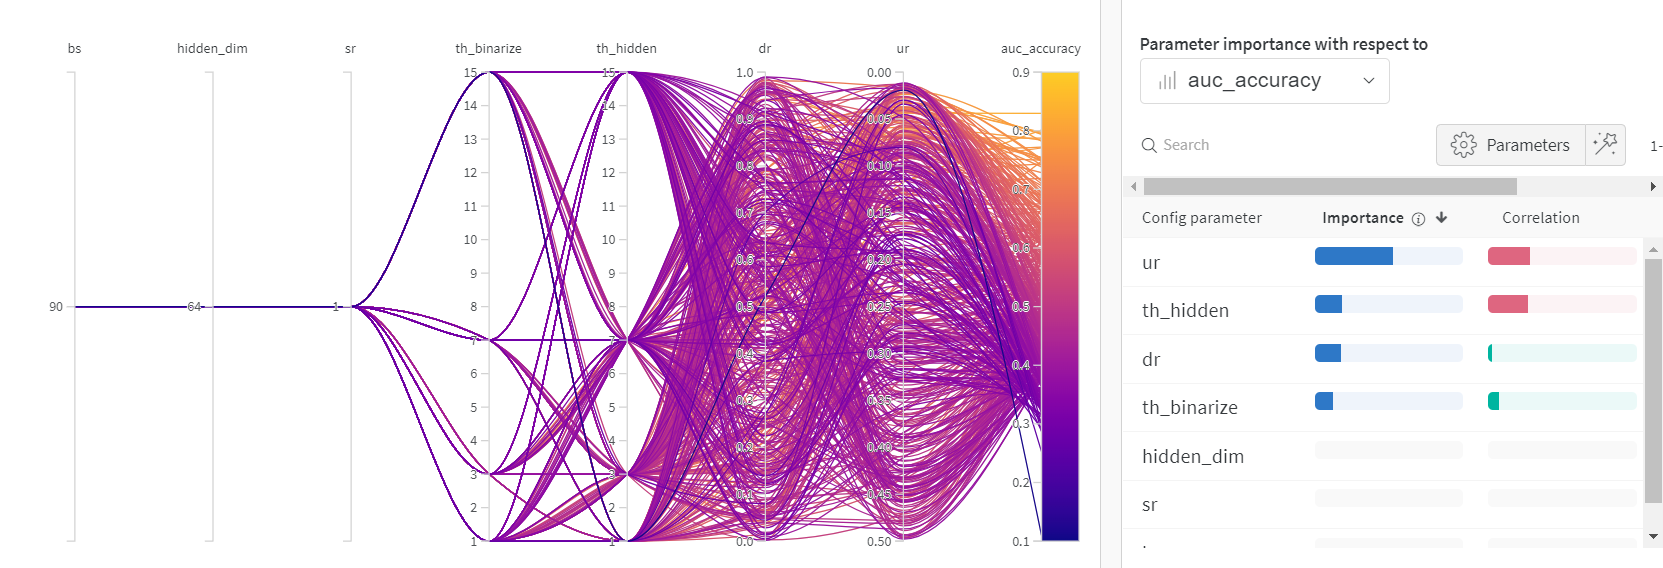

In [ ]:
ln.enable_log_heatmap = False
sweep_config = yaml.safe_load("""
# project: iris_ln  # edit if needed
# name: iris_ln_sweep  # edit if needed
# entity: (user_name)  # edit if needed
method: bayes  # or grid,random
metric: 
    name: auc_accuracy  # target to optimize
    goal: maximize  # or minimize
parameters:
    ur: # update_rate
        min: .01
        max: .5
    sr: # suppressor_rate
        min: .0
        max: .75
    th_binarize: # threshold when binarize
        values: [1,3,7,15]
    th_hidden: # threshold inner layers
        values: [1,3,7,15]
    hidden_dim:
        values: [8,16,24,32,48,64]
    bs: # batch size
        values: [16,32,64,120]
""")

def train():
    wandb.init()
    hps = wandb.config  # Get hyperparameters for this run from W&B
    ln.suppressor_rate = hps.sr
    model = Model01(input_dim, hps.hidden_dim, output_dim, ln.TH_DICT[hps.th_binarize], ln.TH_DICT[hps.th_hidden])
    def build_learn(dls, ur_range):
        learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                   cbs=[
                       ln.TLogicWandbCallback(),
                   ])
        ln.setup_cbs(learn, ur_range=ur_range)
        return learn
    # 1st learn
    learn = build_learn(build_dls(bs=hps.bs), ur_range=(hps.ur, hps.ur/10))
    learn.fit(10)
    # # 2nd learn
    # learn = build_learn(build_dls(bs=len(learn.dls.train_ds)), ur_range=hps.ur2)
    # learn.fit(10)

# Run the sweep
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train)